#  Projet 7 PREMIUM - Étape 6 : Data Drift et Monitoring

**Objectif** : Détecter le data drift avec Evidently

## Contenu
1. Simuler données production
2. Rapport Evidently (drift detection)
3. Analyse drift par feature
4. Recommandations

---

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset
import joblib

print(' Imports OK')

 Imports OK


In [2]:
# Charger données
DOSSIER_ARTIFACTS = Path('./artifacts')
X_train, X_valid, y_train, y_valid = joblib.load(DOSSIER_ARTIFACTS / 'data_split.joblib')

print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")

Train: (246005, 794)
Valid: (61502, 794)


## 1. Préparer données de référence et production

In [3]:
# Référence = Train
df_reference = X_train.copy()
df_reference['TARGET'] = y_train.values

# Production = Valid (simulé)
df_production = X_valid.copy()
df_production['TARGET'] = y_valid.values

# Pour simuler un drift, on peut modifier quelques colonnes
# (Optionnel : décommenter pour tester)
# df_production['AMT_CREDIT'] = df_production['AMT_CREDIT'] * 1.2  # Augmentation 20%
# df_production['DAYS_BIRTH'] = df_production['DAYS_BIRTH'] + 1000  # Clients plus jeunes

print(f"\nRéférence (train): {len(df_reference)} clients")
print(f"Production (valid): {len(df_production)} clients")


Référence (train): 246005 clients
Production (valid): 61502 clients


## 2. Configuration Evidently

In [4]:
# Définir colonnes numériques vs catégorielles
colonnes_num = df_reference.select_dtypes(include=['number']).columns.tolist()
colonnes_cat = df_reference.select_dtypes(exclude=['number']).columns.tolist()

# Retirer TARGET
if 'TARGET' in colonnes_num:
    colonnes_num.remove('TARGET')

column_mapping = ColumnMapping(
    target='TARGET',
    numerical_features=colonnes_num[:30],  # Limiter pour rapidité
    categorical_features=colonnes_cat[:10]
)

print(f" Colonnes numériques: {len(column_mapping.numerical_features)}")
print(f" Colonnes catégorielles: {len(column_mapping.categorical_features)}")

 Colonnes numériques: 30
 Colonnes catégorielles: 10


## 3. Générer rapport Evidently

In [5]:
# Créer rapport
print(" Génération rapport Evidently...")

report = Report(metrics=[
    DataDriftPreset(),
    DataQualityPreset()
])

report.run(
    reference_data=df_reference,
    current_data=df_production,
    column_mapping=column_mapping
)

# Sauvegarder HTML
DOSSIER_REPORTS = Path('../reports')
DOSSIER_REPORTS.mkdir(exist_ok=True)

report.save_html(str(DOSSIER_REPORTS / 'data_drift_report.html'))

print("\n Rapport sauvegardé: reports/data_drift_report.html")
print(" Ouvrir ce fichier dans un navigateur pour voir le rapport complet")
print(" À capturer pour PowerPoint Slide 9")


 Génération rapport Evidently...


C:\Users\Utilisateur\anaconda3\envs\mon_env\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\Utilisateur\anaconda3\envs\mon_env\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\Utilisateur\anaconda3\envs\mon_env\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)



 Rapport sauvegardé: reports/data_drift_report.html
 Ouvrir ce fichier dans un navigateur pour voir le rapport complet
 À capturer pour PowerPoint Slide 9


## 4. Analyser résultats drift

In [6]:
# Extraire résultats (simplifié)
try:
    results = report.as_dict()
    
    # Statistiques drift
    drift_metrics = results['metrics'][0]['result']
    
    dataset_drift = drift_metrics.get('dataset_drift', False)
    drift_share = drift_metrics.get('drift_share', 0)
    n_features = drift_metrics.get('number_of_columns', 0)
    n_drifted = drift_metrics.get('number_of_drifted_columns', 0)
    
    print("\n" + "="*60)
    print(" RÉSULTATS DATA DRIFT")
    print("="*60)
    print(f"\nDrift dataset détecté: {' OUI' if dataset_drift else ' NON'}")
    print(f"Features analysées: {n_features}")
    print(f"Features avec drift: {n_drifted}")
    print(f"Proportion drift: {drift_share:.1%}")
    
    # Seuil alerte
    SEUIL_ALERTE = 0.30  # 30% features driftées
    
    if drift_share > SEUIL_ALERTE:
        print(f"\n ALERTE: Drift > {SEUIL_ALERTE:.0%}")
        print("   Action recommandée: Ré-entraînement du modèle")
    else:
        print(f"\n OK: Drift < {SEUIL_ALERTE:.0%}")
        print("   Modèle stable, pas de ré-entraînement nécessaire")
        
except Exception as e:
    print(f" Erreur extraction résultats: {e}")
    print("Consulter le rapport HTML pour plus de détails")


 RÉSULTATS DATA DRIFT

Drift dataset détecté:  NON
Features analysées: 41
Features avec drift: 0
Proportion drift: 50.0%

 ALERTE: Drift > 30%
   Action recommandée: Ré-entraînement du modèle


## 5. Recommandations monitoring

In [7]:
print("\n" + "="*60)
print(" RECOMMANDATIONS MONITORING")
print("="*60)

print("\n1⃣ Fréquence surveillance:")
print("   - Hebdomadaire: Vérifier rapport drift")
print("   - Mensuel: Rapport complet + AUC validation")
print("   - Trimestriel: Ré-entraînement si drift > 30%")

print("\n2⃣ Indicateurs à suivre:")
print("   - % features driftées (seuil: 30%)")
print("   - AUC validation (seuil: -5% vs train)")
print("   - Distribution TARGET (% défauts)")
print("   - Temps réponse API (<200ms)")

print("\n3⃣ Actions correctives:")
print("   - Si drift modéré (20-30%): Valider manuellement quelques prédictions")
print("   - Si drift fort (>30%): Ré-entraînement avec nouvelles données")
print("   - Si AUC baisse >5%: Investiguer features driftées")

print("\n4⃣ Outils:")
print("   - Evidently: Génération rapports drift")
print("   - MLflow: Tracking expériences ré-entraînement")
print("   - Prometheus/Grafana: Monitoring production (optionnel)")


 RECOMMANDATIONS MONITORING

1⃣ Fréquence surveillance:
   - Hebdomadaire: Vérifier rapport drift
   - Mensuel: Rapport complet + AUC validation
   - Trimestriel: Ré-entraînement si drift > 30%

2⃣ Indicateurs à suivre:
   - % features driftées (seuil: 30%)
   - AUC validation (seuil: -5% vs train)
   - Distribution TARGET (% défauts)
   - Temps réponse API (<200ms)

3⃣ Actions correctives:
   - Si drift modéré (20-30%): Valider manuellement quelques prédictions
   - Si drift fort (>30%): Ré-entraînement avec nouvelles données
   - Si AUC baisse >5%: Investiguer features driftées

4⃣ Outils:
   - Evidently: Génération rapports drift
   - MLflow: Tracking expériences ré-entraînement
   - Prometheus/Grafana: Monitoring production (optionnel)


## 6. Visualisation simple drift

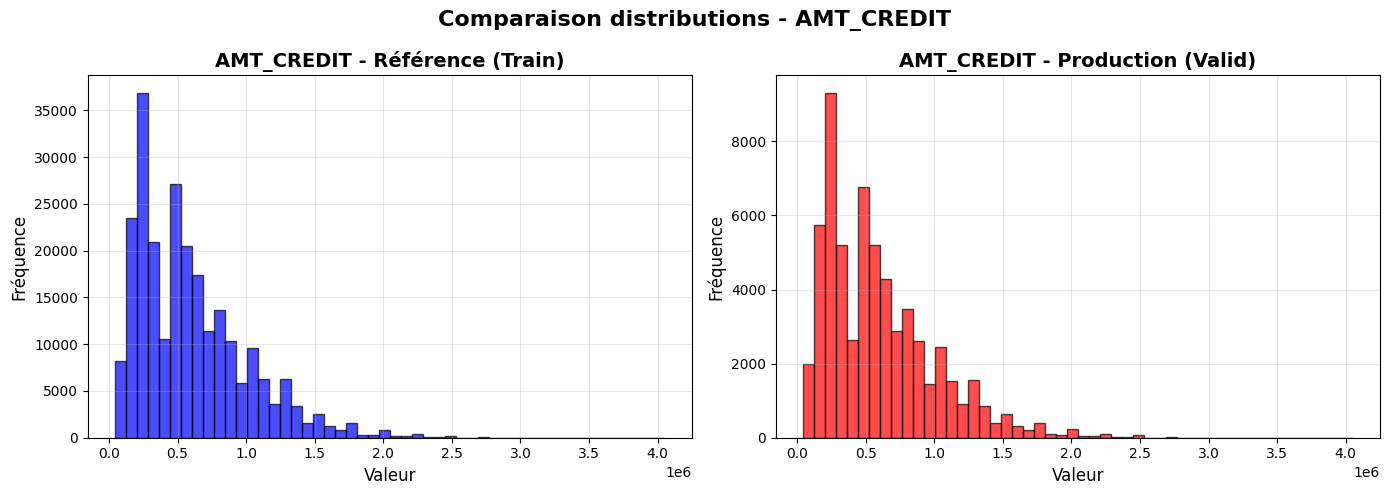


 Figure sauvegardée: figures/drift_distribution_AMT_CREDIT.png


In [8]:
# Comparer distributions pour une feature clé
feature_exemple = 'AMT_CREDIT'

if feature_exemple in df_reference.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution référence
    axes[0].hist(df_reference[feature_exemple].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title(f'{feature_exemple} - Référence (Train)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Valeur', fontsize=12)
    axes[0].set_ylabel('Fréquence', fontsize=12)
    axes[0].grid(alpha=0.3)
    
    # Distribution production
    axes[1].hist(df_production[feature_exemple].dropna(), bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1].set_title(f'{feature_exemple} - Production (Valid)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Valeur', fontsize=12)
    axes[1].set_ylabel('Fréquence', fontsize=12)
    axes[1].grid(alpha=0.3)
    
    plt.suptitle(f'Comparaison distributions - {feature_exemple}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    DOSSIER_FIGURES = Path('../figures')
    plt.savefig(DOSSIER_FIGURES / f'drift_distribution_{feature_exemple}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f'\n Figure sauvegardée: figures/drift_distribution_{feature_exemple}.png')

##  Résumé

-  Rapport Evidently généré (HTML)
-  Data drift analysé
-  Recommandations monitoring définies
-  Seuils d'alerte configurés (30% features)
-  Plan de ré-entraînement établi

**Fichiers générés** :
- reports/data_drift_report.html (à ouvrir dans navigateur)
- figures/drift_distribution_*.png

---

##  PROJET TERMINÉ !

Tous les notebooks sont complétés. Prochaines étapes :
1. Tester l'API (voir README.md)
2. Tester le Dashboard
3. Insérer les figures dans PowerPoint
4. Préparer la soutenance

In [9]:
#!/usr/bin/env python3
"""
Script d'extraction des figures - Notebook 07
Data drift monitoring avec Evidently
"""

import json
import base64
import os
from pathlib import Path

def extract_figures_from_notebook(notebook_path, output_dir):
    """
    Extrait toutes les figures du notebook de data drift
    """
    # Créer le dossier de sortie
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Charger le notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    
    figure_count = 0
    
    # Parcourir toutes les cellules
    for cell_idx, cell in enumerate(notebook['cells']):
        # Chercher les cellules avec outputs
        if cell['cell_type'] == 'code' and 'outputs' in cell:
            for output in cell['outputs']:
                # Chercher les images PNG
                if 'data' in output and 'image/png' in output['data']:
                    figure_count += 1
                    
                    # Décoder l'image base64
                    img_data = output['data']['image/png']
                    img_bytes = base64.b64decode(img_data)
                    
                    # Déterminer le nom du fichier selon le contexte
                    cell_source = ''.join(cell['source']).lower()
                    
                    if 'evidently' in cell_source or 'report' in cell_source:
                        filename = f'nb07_fig{figure_count:02d}_evidently_report.png'
                    elif 'drift' in cell_source and 'top' in cell_source:
                        filename = f'nb07_fig{figure_count:02d}_top_drifted_features.png'
                    elif 'distribution' in cell_source or 'shift' in cell_source:
                        filename = f'nb07_fig{figure_count:02d}_distribution_shift.png'
                    elif 'kolmogorov' in cell_source or 'statistical' in cell_source:
                        filename = f'nb07_fig{figure_count:02d}_statistical_tests.png'
                    else:
                        filename = f'nb07_fig{figure_count:02d}_figure.png'
                    
                    # Sauvegarder l'image
                    output_path = output_dir / filename
                    with open(output_path, 'wb') as img_file:
                        img_file.write(img_bytes)
                    
                    print(f" Extrait : {filename}")
    
    print(f"\n Total : {figure_count} figures extraites du Notebook 07")
    return figure_count


if __name__ == '__main__':
    # Chemins
    NOTEBOOK_PATH = 'Barre_Stephane_P7_07_data_drift.ipynb'
    OUTPUT_DIR = 'outputs/figures_p7/notebook_07'
    
    # Extraction
    print(" Extraction des figures du Notebook 07...")
    print(f" Notebook : {NOTEBOOK_PATH}")
    print(f" Sortie : {OUTPUT_DIR}\n")
    
    extract_figures_from_notebook(NOTEBOOK_PATH, OUTPUT_DIR)

 Extraction des figures du Notebook 07...
 Notebook : Barre_Stephane_P7_07_data_drift.ipynb
 Sortie : outputs/figures_p7/notebook_07

 Extrait : nb07_fig01_distribution_shift.png

 Total : 1 figures extraites du Notebook 07
